# Laser Detection for one Star

In [1]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
import math
from mpmath import mp
import os
import os.path 
import random
from random import seed
from random import choice

## Signal Injection
Copied from Anna Zuckerman's Github repository: https://github.com/annazuckerman/specmatch-emp-apf

In [2]:
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)

# function to insert simulated gaussians
def insert_gaussian(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be odd            #### why does this start at 0?
    gauss = gaussian(x,height,position,FWHM/(2*np.sqrt(2*np.log(2))),offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = gauss
    return new_spect
    
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)

## Read in Reduced Data from Anna Zuckerman's repo

In [3]:
APF_wavelength_path = '/mnt_home/zoek/code/APF-BL-DAP/APFTutorial/apf_wav.fits'
directory = '/mnt_home/azuckerman/APF_spectra/NDR'

list_of_files = []
for filename in os.listdir(directory):
    if filename.endswith(".fits"): 
        file_path = os.path.join(directory, filename)
        list_of_files = np.append(list_of_files, file_path)
        
APF_flux_path = list_of_files[0]
print(APF_flux_path)

/mnt_home/azuckerman/APF_spectra/NDR/ramq.233.NDR.fits


## Set parameters

In [4]:
plot = True
save_figs = False
inject_signals = True
threshold_testing = True

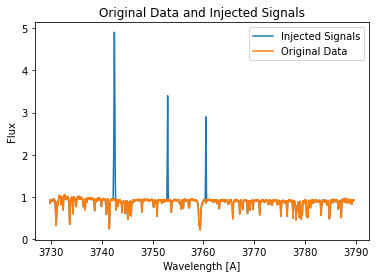

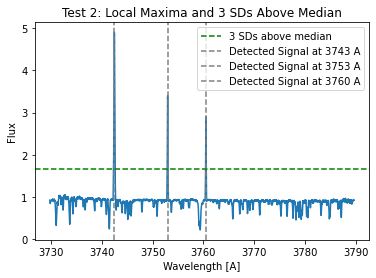

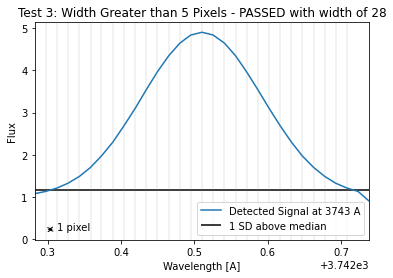

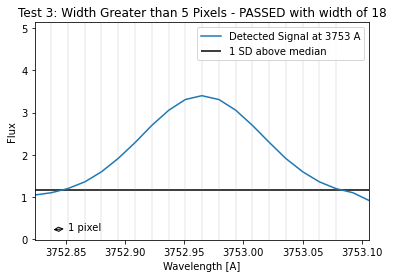

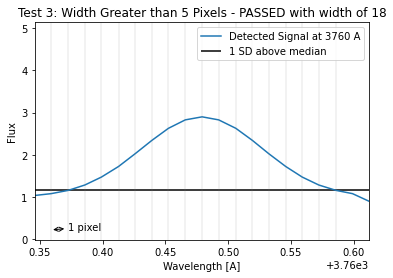

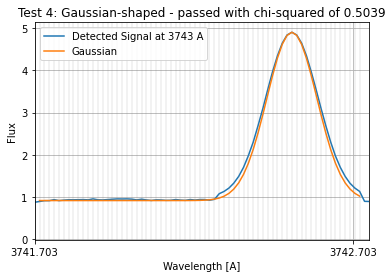

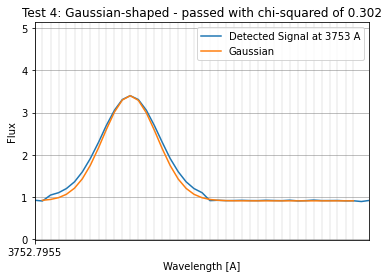

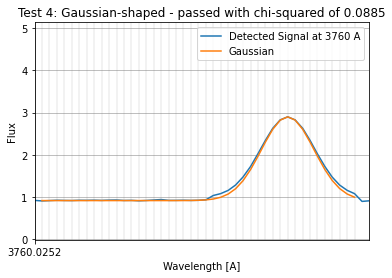

803
803.0
1516
1516.0
2063
2063.0


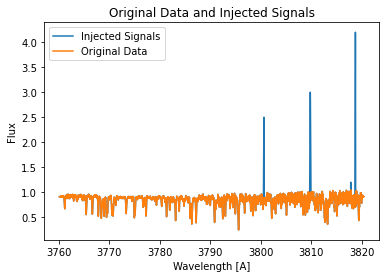

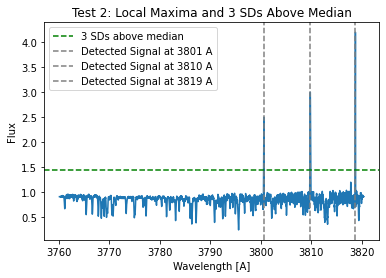

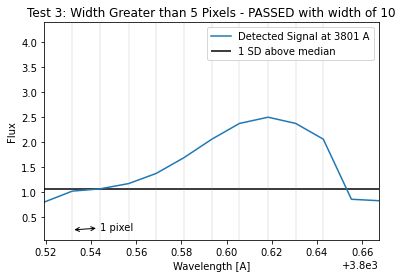

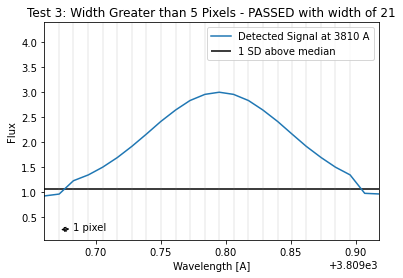

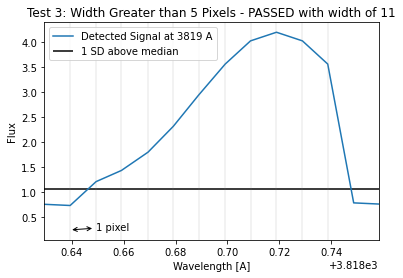

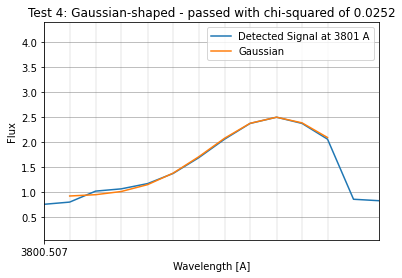

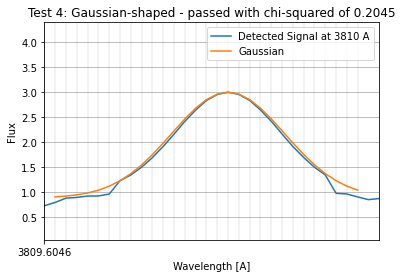

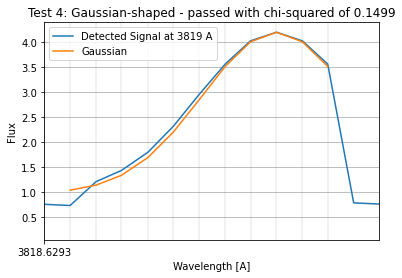

2805
2803.0
3585
3585.0
4430
4428.0


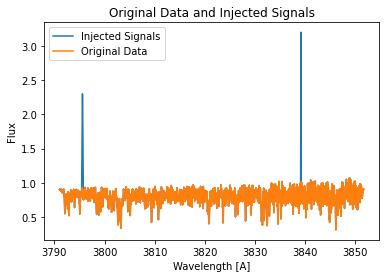

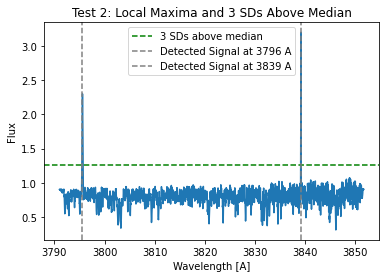

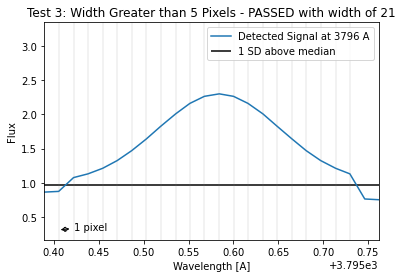

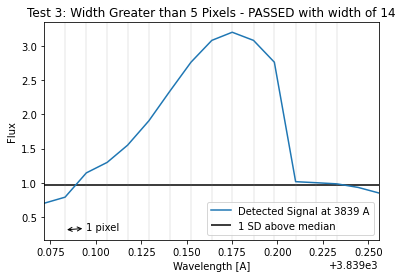

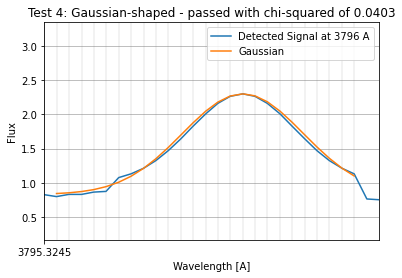

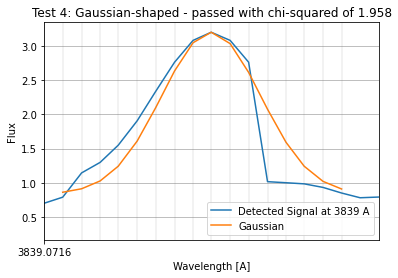

280
280.0
3423
3421.0


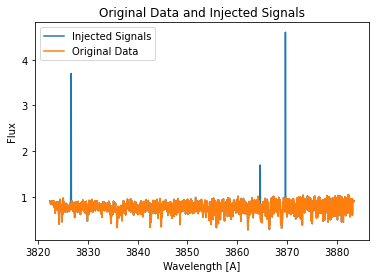

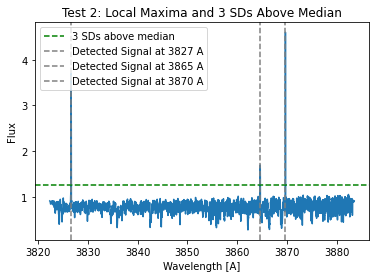

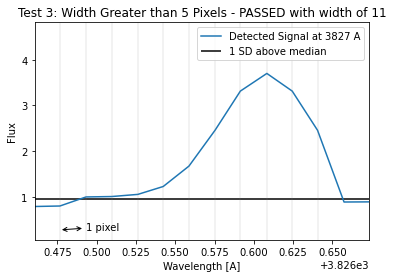

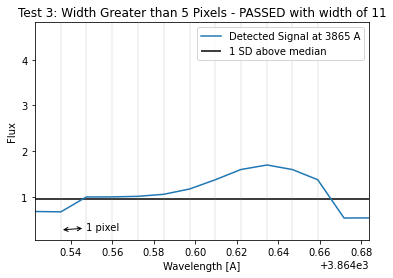

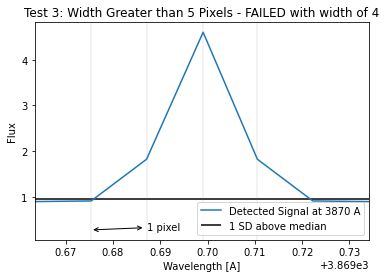

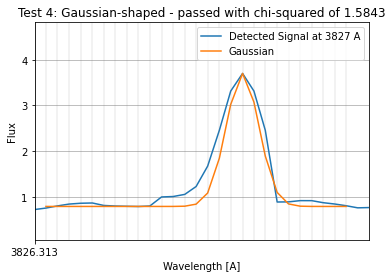

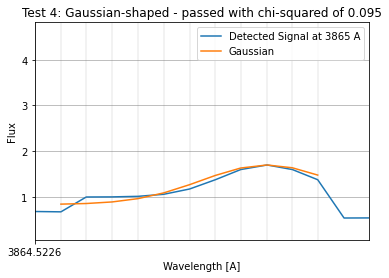

259
257.0
2901
2899.0


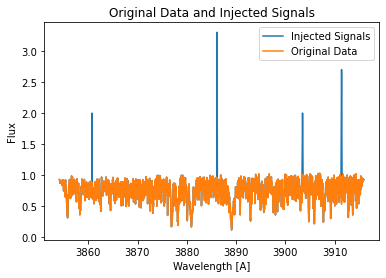

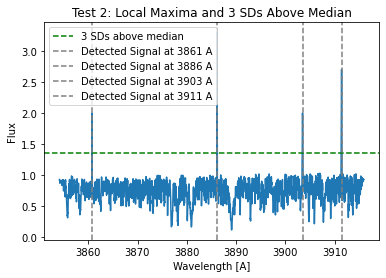

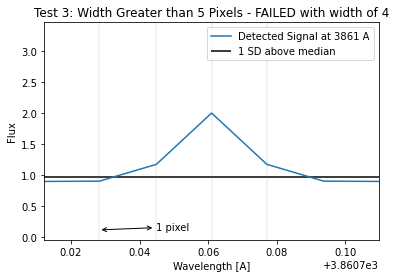

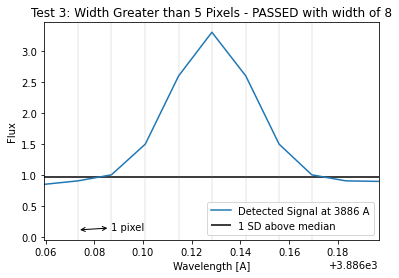

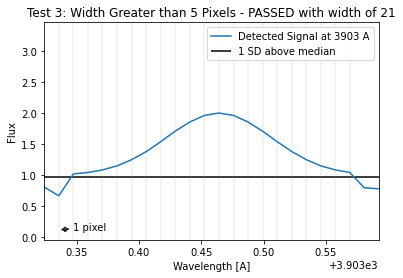

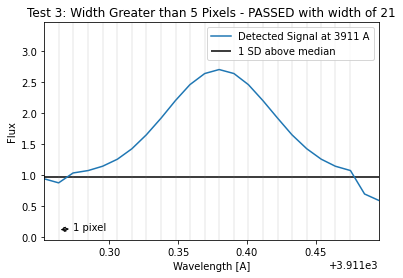

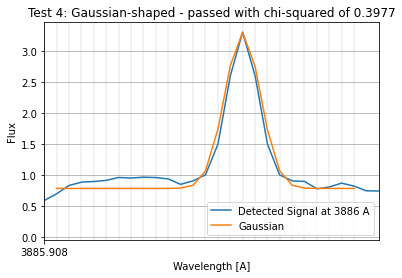

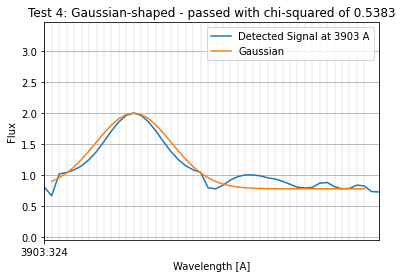

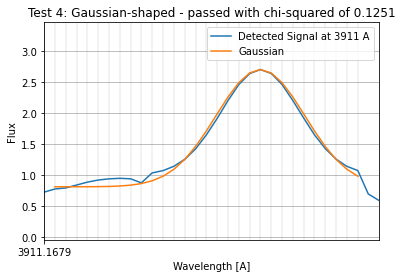

2085
2086.0
3449
3449.0
4160
4160.0


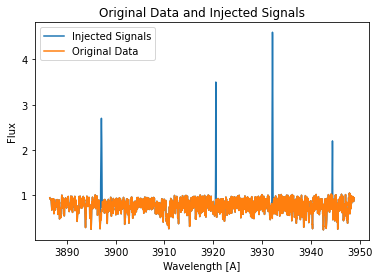

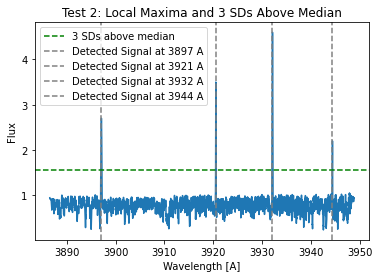

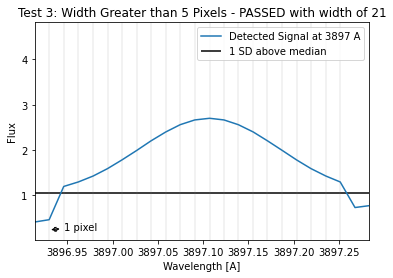

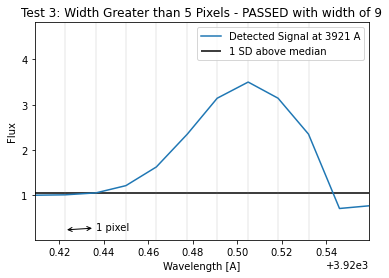

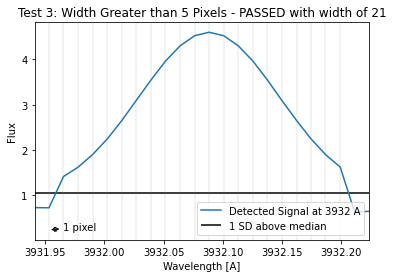

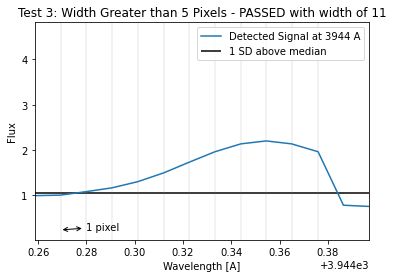

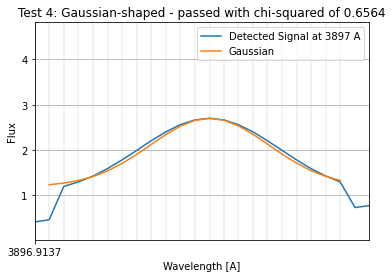

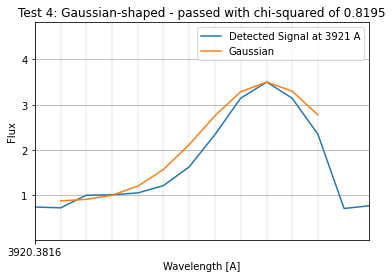

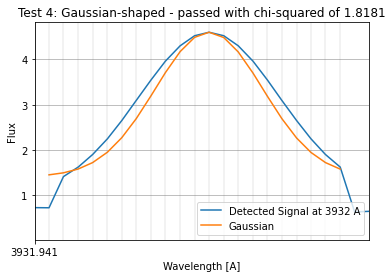

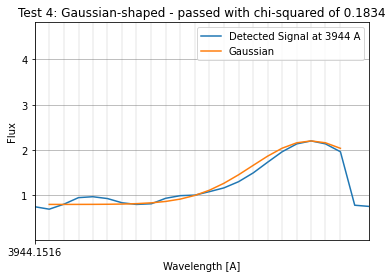

637
637.0
2210
2208.0
3102
3102.0
4170
4168.0


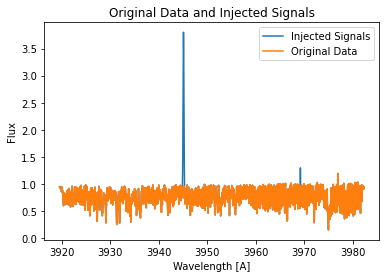

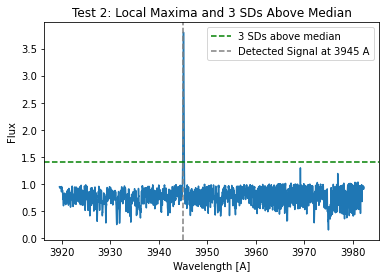

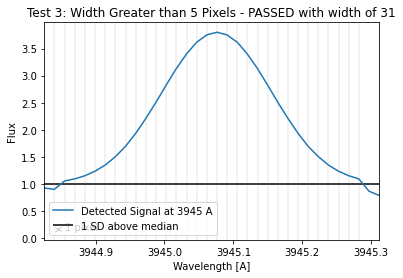

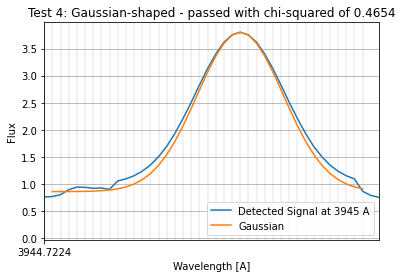

1603
1603.0


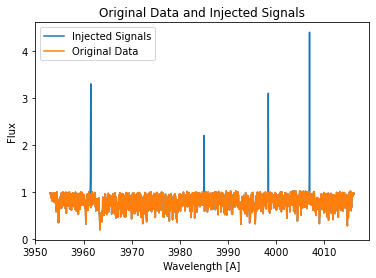

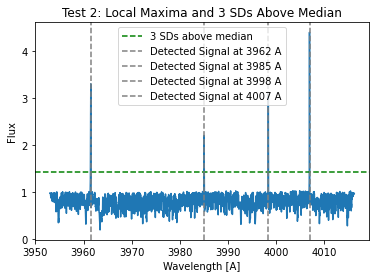

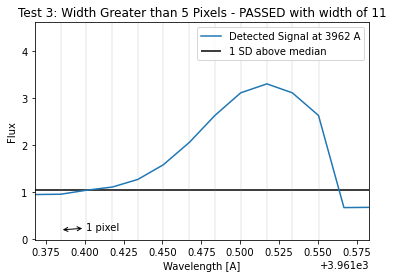

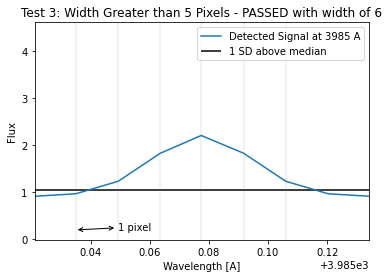

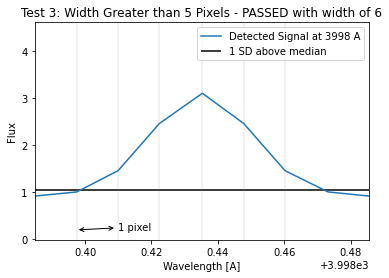

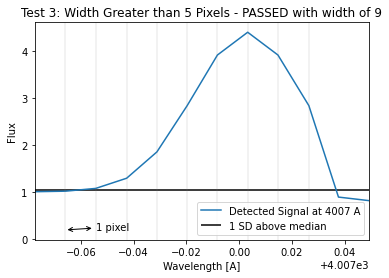

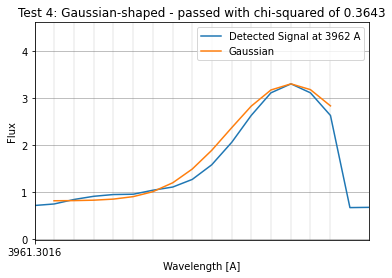

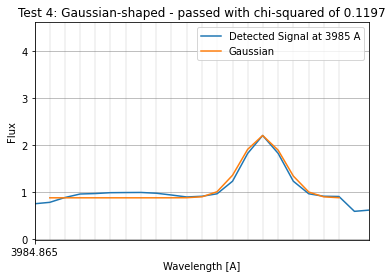

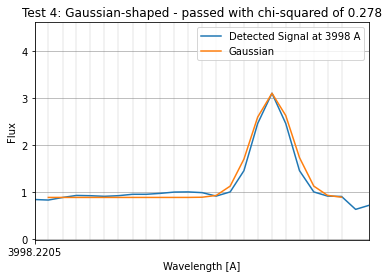

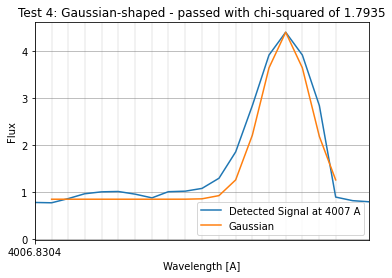

503
501.0
2036
2037.0
3033
3034.0
3743
3741.0


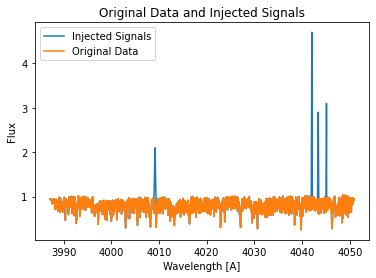

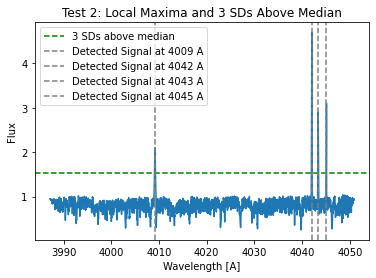

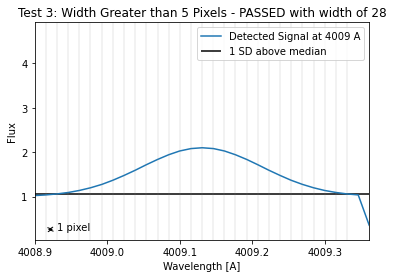

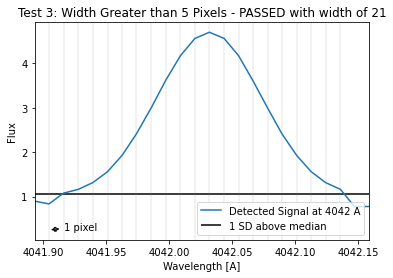

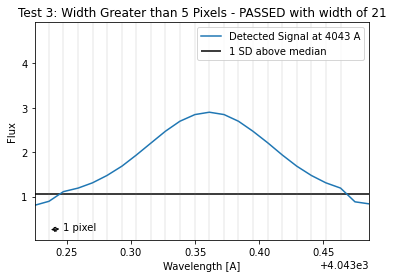

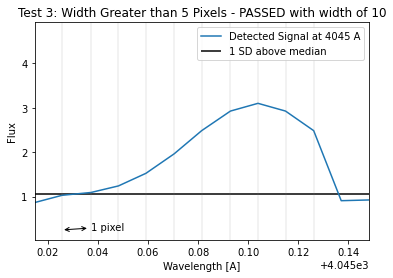

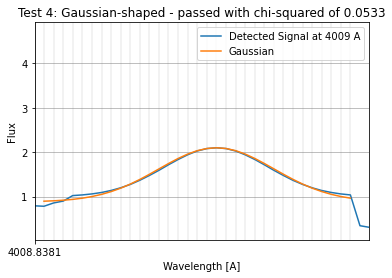

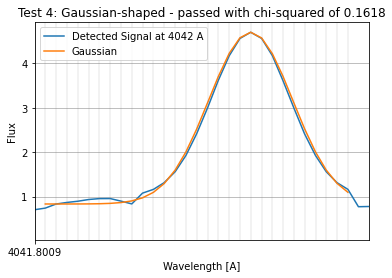

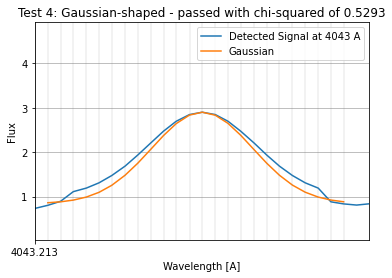

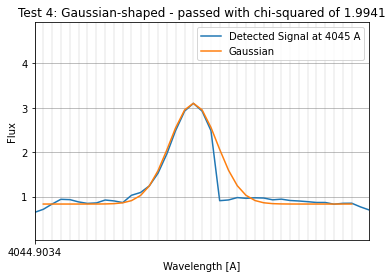

1342
1342.0
3785
3785.0
3901
3901.0
4056
4054.0


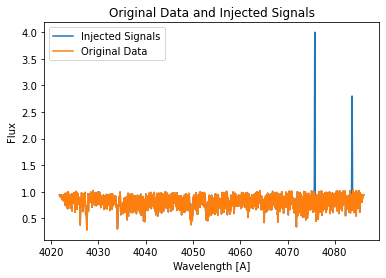

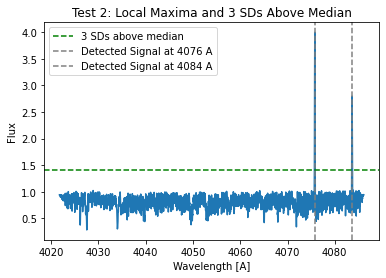

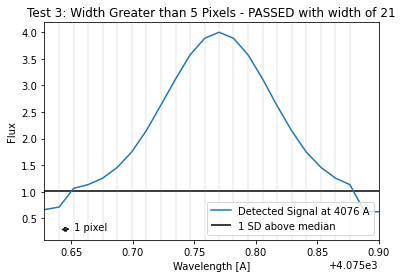

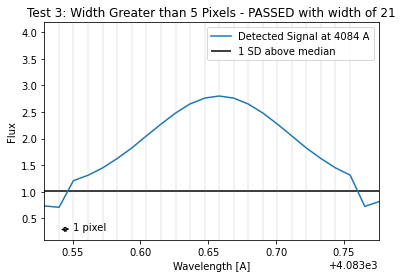

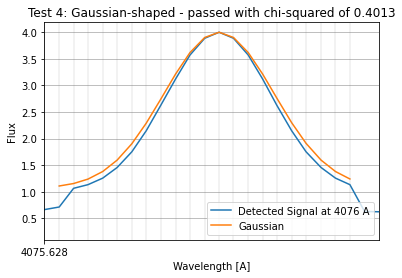

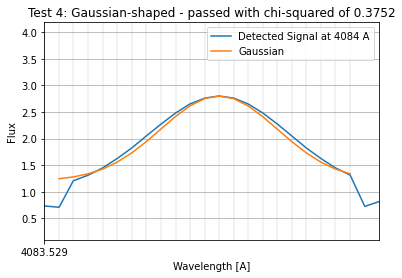

3665
3665.0
4364
4364.0


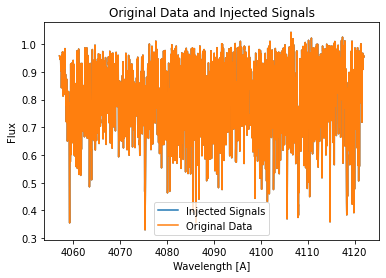

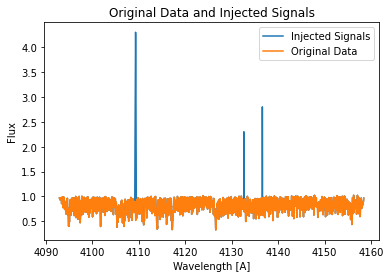

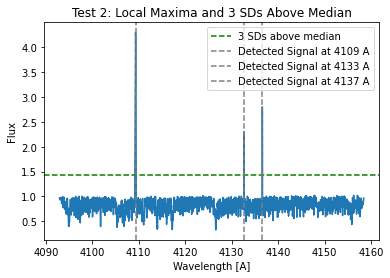

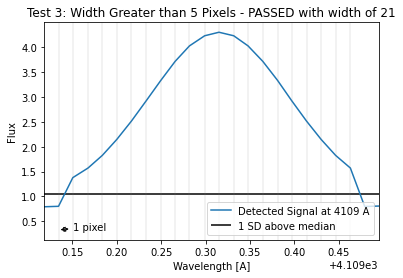

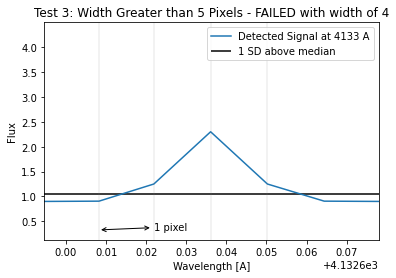

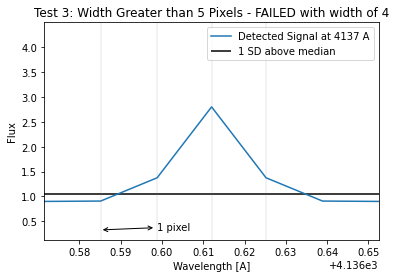

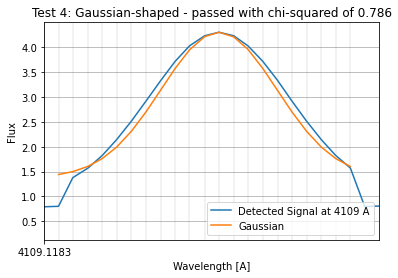

954
954.0


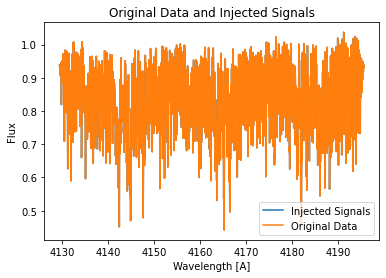

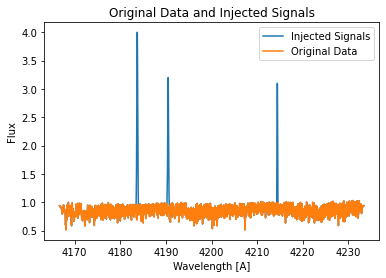

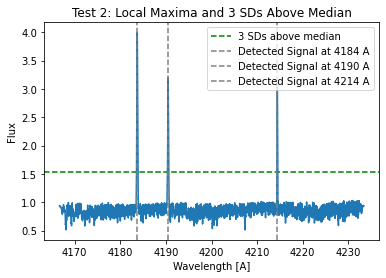

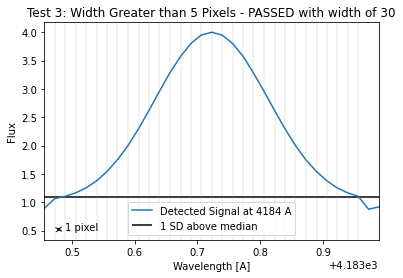

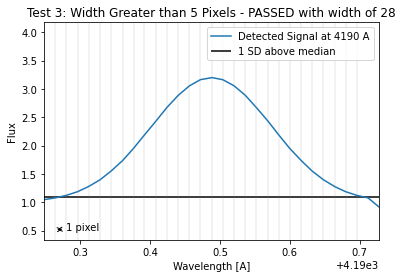

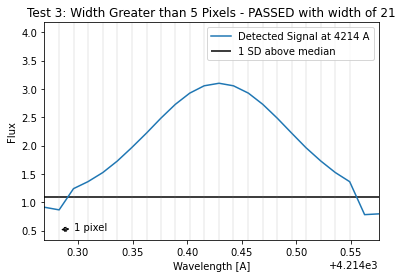

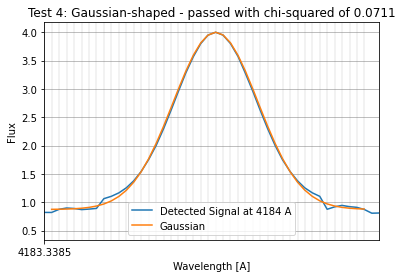

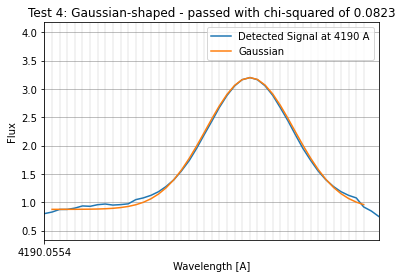

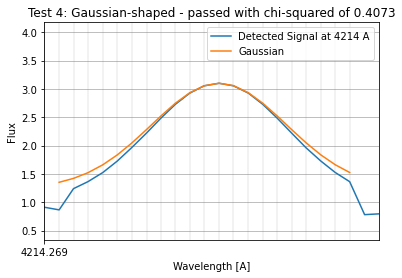

976
976.0
1390
1390.0
3023
3023.0


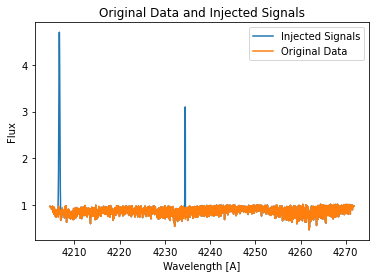

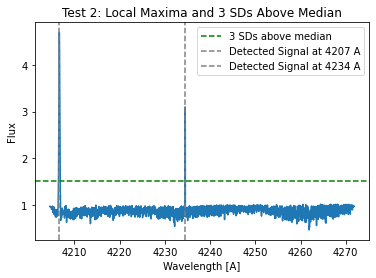

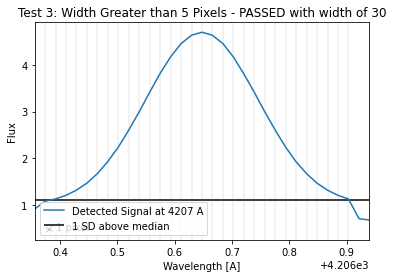

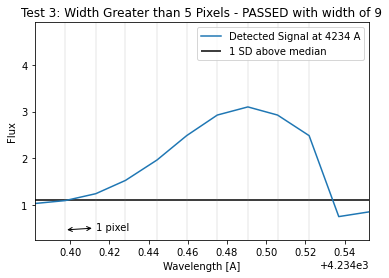

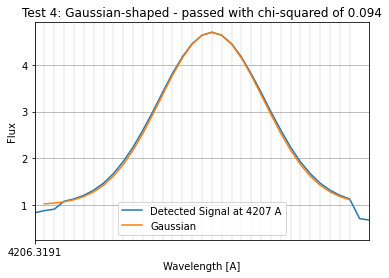

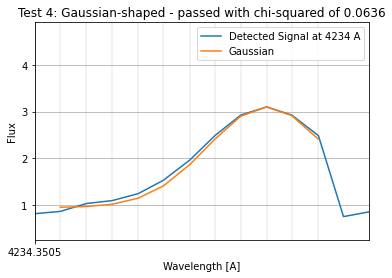

115
115.0
1763
1761.0


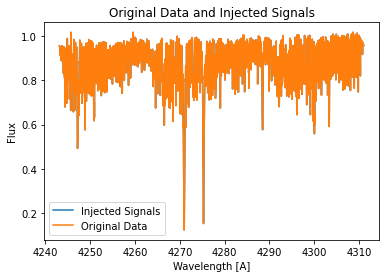

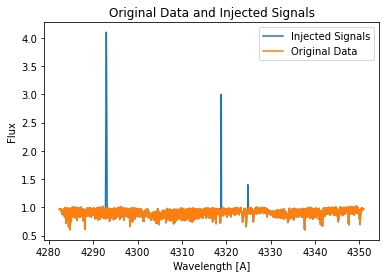

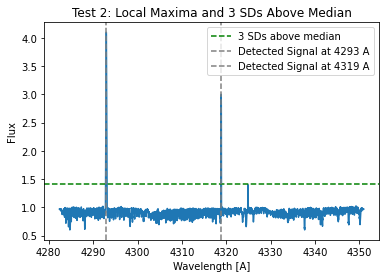

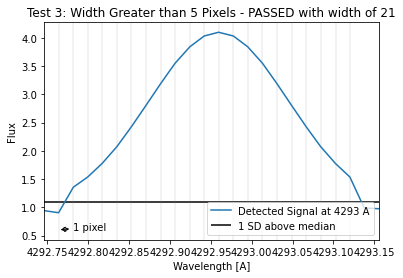

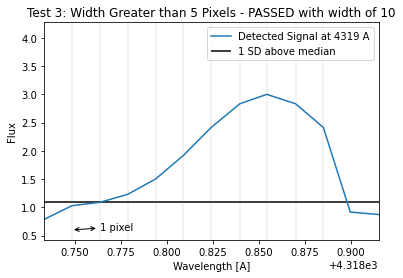

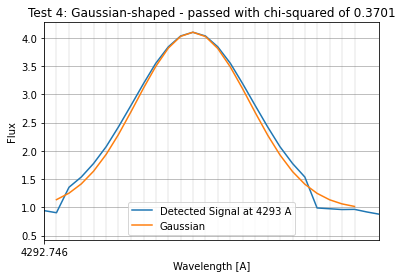

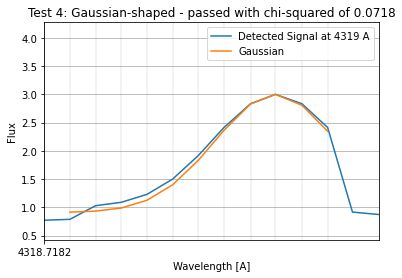

577
577.0
2147
2145.0


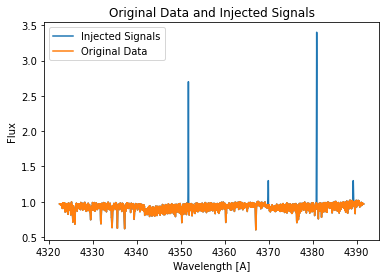

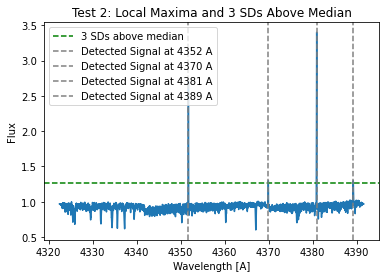

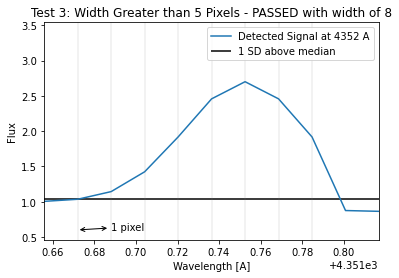

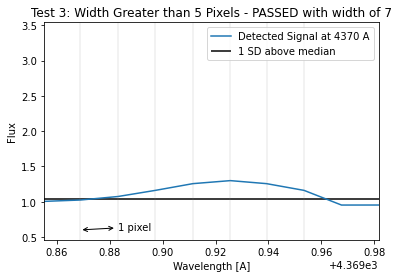

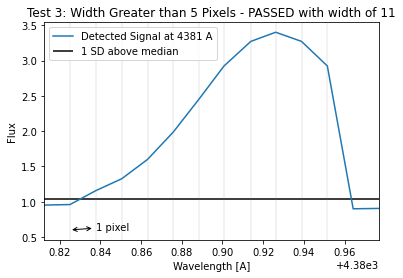

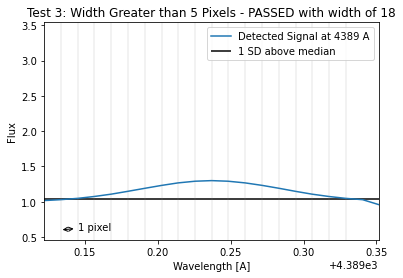

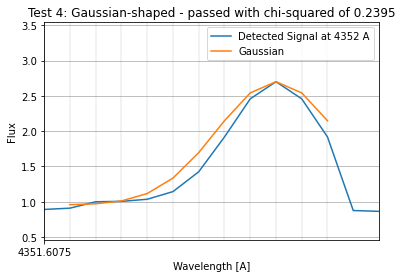

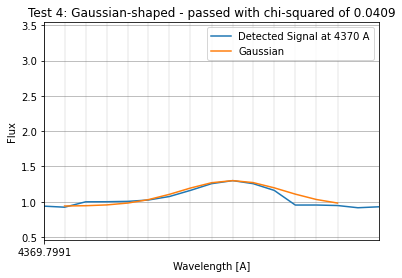

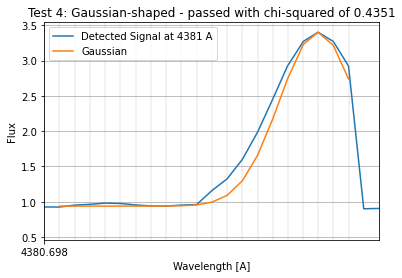

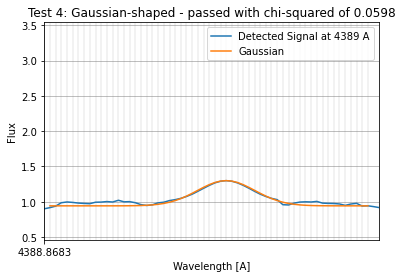

1672
1670.0
2876
2874.0
3699
3697.0
4387
4387.0


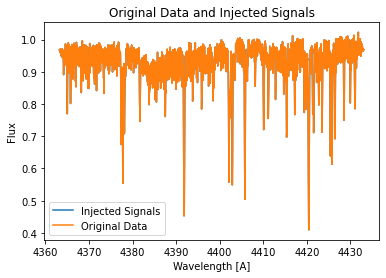

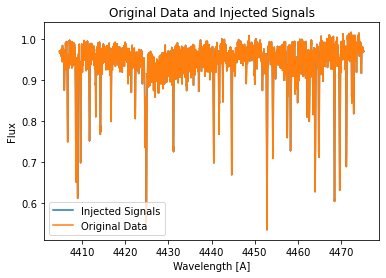

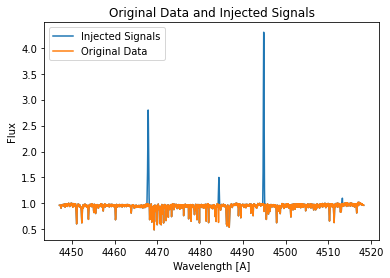

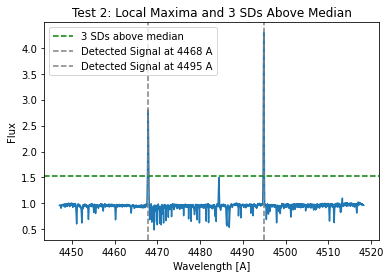

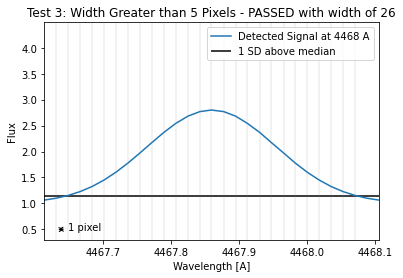

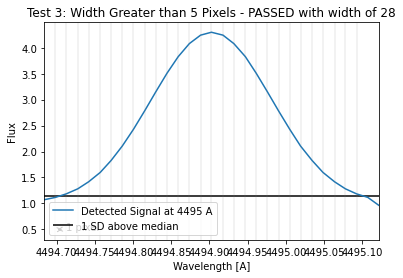

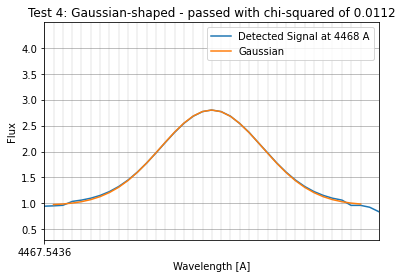

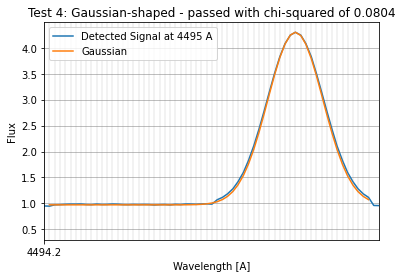

1120
1120.0
2802
2802.0


In [6]:
wl_file = fits.open(APF_wavelength_path)
wl_image = wl_file[0].data
fl_file = fits.open(APF_flux_path)
fl = fl_file[0].data
header = fl_file[0].header
star = header['TOBJECT']


heights = []
widths = []
indicies = []
recovered_widths = []
recovered_heights = []
recovered_indicies = []

for order in np.arange(21):
    
    wl = wl_image[order][4:-3]
    flux = fl[order]
    spect = flux
    if inject_signals == True:
        signals = np.random.randint(0,5)
        for i in np.arange(signals):
            random_val = np.random.choice(flux[100:-100], size = 1)
            location = flux.tolist().index(random_val)
            height = choice(np.arange(0.1, 4, 0.1).tolist())
            width = choice(np.arange(1, 10).tolist())
            if width > 8:
                spect = insert_gaussian(spect,[height, 15, width, 1], location, 30)
            elif width > 5:
                spect = insert_gaussian(spect,[height, 10, width, 1], location, 20)
            elif width > 2:
                spect = insert_gaussian(spect,[height, 7, width, 1], location, 10)
            else:
                spect = insert_gaussian(spect,[height, 4, width, 0.9], location, 10)
            heights = np.append(heights, height)
            widths = np.append(widths, width)
            indicies = np.append(indicies, location)
        if (plot == True) or (save_figs == True):
            fig = plt.figure()
            plt.plot(wl, spect, label = 'Injected Signals')
            plt.plot(wl, flux, label = 'Original Data')
            plt.title('Original Data and Injected Signals')
            plt.xlabel('Wavelength [A]')
            plt.ylabel('Flux')
            plt.legend()
        if plot == True:
            plt.show()
        if save_figs == True:
            path = '/mnt_home/zoek/code/APF-BL-DAP/LaserDetectionResults/' + star
            if not (os.path.isdir(path)):
                os.mkdir(path)
            path = path + '/order' + str(order)
            if not (os.path.isdir(path)):
                os.mkdir(path)
            fig.savefig(path + '/' + star + '_order' + str(order) + '_injected_signals.png')
            
            

    median = np.median(spect)
    SD = np.std(spect)

    idxs1 = [] # indicies that are 3 SDs above the median flux value
    idxs2 = [] # indicies in idxs1 that are local maximums
    idxs3 = [] # indicies in idxs2 that are greater than 5 pixels in width
    idxs4 = [] # indicies in idxs3 that are gaussian-shaped

    for idx in np.arange(len(spect)):
        # first test: create an array of all indices that are above 3 SDs above median
        if spect[idx] > 3 * SD + median:
            idxs1 = idxs1 + [idx]
            
    for idx in idxs1:            
        # second test: keep the index if it is a local maximum  
        if spect[idx] >= spect[idx-1] and spect[idx] >= spect[idx+1]: 
            if spect[idx] >= spect[idx-2] and spect[idx] >= spect[idx+2]:
                idxs2 = idxs2 + [idx]
    if (plot == True or save_figs == True) & (idxs2 != []):
        fig = plt.figure()
        plt.plot(wl, spect)
        plt.axhline(3*SD + median, label= '3 SDs above median', color='green', linestyle='--')
        for ind in idxs2:
            plt.axvline(x=wl[ind], label= 'Detected Signal at ' + str(round(wl[ind])) + ' A', color='gray', linestyle='--')    
        plt.title('Test 2: Local Maxima and 3 SDs Above Median')
        plt.xlabel('Wavelength [A]')
        plt.ylabel('Flux')
        plt.legend() 
        if plot == True:
            plt.show()
        if save_figs == True:
            path = '/mnt_home/zoek/code/APF-BL-DAP/LaserDetectionResults/' + star
            if not (os.path.isdir(path)):
                os.mkdir(path)
            path = path + '/order' + str(order)
            if not (os.path.isdir(path)):
                os.mkdir(path)
            fig.savefig(path + '/' + star + '_order' + str(order) + '_test2.png')
            
    for idx in idxs2:
        # third test: determine if the signal is greater than 5 pixels in width 
        # determine the left and right bounds of the peak - the left and rightmost points where
        # the flux value falls under the median + 1 SD     
        temp_ind = idx
        left_bound = 0
        while temp_ind > 0:
            temp_ind -= 1
            if spect[temp_ind] < median + SD:
                left_bound = temp_ind
                break
        temp_ind = idx
        right_bound = len(spect)
        while temp_ind < len(spect):
            temp_ind += 1
            if spect[temp_ind] < median + SD:
                right_bound = temp_ind
                break
        passed = False
        if ((right_bound - left_bound) > 5):
            passed = True
            idxs3 = idxs3 + [idx]
        if (plot == True or save_figs == True):
            fig = plt.figure()
            plt.plot(wl, spect, label = 'Detected Signal at ' + str(round(wl[idx])) + ' A') 
            if passed:
                plt.title('Test 3: Width Greater than 5 Pixels - PASSED with width of ' + str(right_bound - left_bound))
            else:
                plt.title('Test 3: Width Greater than 5 Pixels - FAILED with width of ' + str(right_bound - left_bound))
            plt.xlabel('Wavelength [A]')
            plt.xlim(wl[left_bound - 1], wl[right_bound + 1])
            plt.hlines(median + SD, wl[left_bound - 1], wl[right_bound + 1], label = '1 SD above median')
            for ind in np.arange(left_bound, right_bound):
                plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
            plt.annotate(s='1 pixel', xy=(wl[left_bound], min(spect)), xytext=(wl[left_bound + 1], min(spect)), arrowprops=dict(arrowstyle='<->'))
            plt.ylabel('Flux')
            plt.legend()
        if plot == True:
            plt.show()
        if save_figs == True:
            test3_path = path + '/test3'
            if not (os.path.isdir(test3_path)):
                os.mkdir(test3_path)
            pos_path = test3_path + '/pass'
            neg_path = test3_path + '/fail'
            if not (os.path.isdir(pos_path) and os.path.isdir(neg_path)):
                os.mkdir(pos_path)
                os.mkdir(neg_path)
            if passed:
                fig.savefig(pos_path + '/test3' + '_' + str(round(wl[idx])) + '.png')
            else:
                fig.savefig(neg_path + '/test3' + '_' + str(round(wl[idx])) + '.png')
                
    for idx in idxs3:
        # fourth test: fit a gaussian to the peak, see how much signal resembles a gaussian
        temp_ind = idx
        left_bound = 0
        while temp_ind > 0:
            temp_ind -= 1
            if spect[temp_ind] < median:
                left_bound = temp_ind
                break
        temp_ind = idx
        right_bound = len(spect)
        while temp_ind < len(spect):
            temp_ind += 1
            if spect[temp_ind] < median:
                right_bound = temp_ind
                break

        x = wl[left_bound:right_bound]
        y = spect[left_bound:right_bound]
        max_y = max(y)
        min_y = np.percentile(y, 5) 
        height = max_y - min_y
        ind = y.tolist().index(max_y)
        pos = x[ind]
        min_width = x[int((len(x) / 2) + 1)] - x[int((len(x) / 2))]
        max_width = x[len(x) - 1] - x[0]
        width_spacing = 0.01

        chi_squared_values = []
        width_vals = np.arange(min_width, max_width, width_spacing)
        for w in width_vals:
            gaus = gaussian(x, height, pos, w, min_y)
            chi_squared = chi(gaus, y)
            chi_squared_values = np.append(chi_squared_values, chi_squared)
        min_chi_squared = min(chi_squared_values)
        ind_of_min_chisquared = chi_squared_values.tolist().index(min_chi_squared)
        width = width_vals[ind_of_min_chisquared]
        gaus = gaussian(x, height, pos, width, min_y)
        passed = False

        if min_chi_squared < 100:
            passed = True
            idxs4 = idxs4 + [idx]

        if plot == True or save_figs == True:
            fig = plt.figure()
            plt.plot(wl, spect, label = 'Detected Signal at ' + str(round(wl[idx])) + ' A')
            plt.plot(x, gaus, label = 'Gaussian')
            if passed == True:
                plt.title('Test 4: Gaussian-shaped - passed with chi-squared of ' + str(round(min_chi_squared, 4)))
            else:
                plt.title('Test 4: Gaussian-shaped - failed with chi-squared of ' + str(round(min_chi_squared, 4)))
            plt.xlabel('Wavelength [A]')
            plt.xlim(wl[left_bound - 1], wl[right_bound + 1])
            plt.ylabel('Flux')
            plt.xticks(np.arange(wl[left_bound - 1], wl[right_bound + 1]))
            plt.grid(which = 'both')
            for ind in np.arange(left_bound, right_bound):
                plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
            plt.legend()
            if plot == True:
                plt.show()
            if save_figs == True:
                test4_path = path + '/test4'
                if not (os.path.isdir(test4_path)):
                    os.mkdir(test4_path)
                pos_path = test4_path + '/pass'
                neg_path = test4_path + '/fail'
                if not (os.path.isdir(pos_path) and os.path.isdir(neg_path)):
                    os.mkdir(pos_path)
                    os.mkdir(neg_path)
                if passed:
                    fig.savefig(pos_path + '/test4' + '_' + str(round(wl[idx])) + '.png')
                else:
                    fig.savefig(neg_path + '/test4' + '_' + str(round(wl[idx])) + '.png')
                    
    if threshold_testing == True:               
        for idx in idxs4:    
            absolute_difference_function = lambda list_value : abs(list_value - idx)
            i = min(indicies.tolist(), key = absolute_difference_function)
            index = indicies.tolist().index(i)
            print(idx)
            print(indicies[index])
            if abs(idx - indicies[index]) < 3 and (indicies[index] not in recovered_indicies):
                recovered_widths = np.append(recovered_widths, widths[index])
                recovered_heights = np.append(recovered_heights, heights[index])
                recovered_indicies = np.append(recovered_indicies, indicies[index])

            

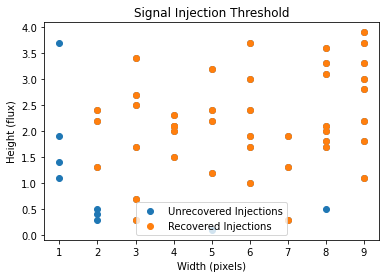

In [7]:
if plot == True or save_figs == True:
    fig = plt.figure()
    plt.scatter(widths, heights, label = 'Unrecovered Injections') 
    plt.scatter(recovered_widths, recovered_heights, label = 'Recovered Injections')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (flux)')
    plt.title('Signal Injection Threshold')
    plt.legend()
    if plot == True:
        plt.show()
    if save_figs == True:
        threshold_path = path + '/' + star + 'threshold'
        fig.savefig(threshold_path)

In [377]:
#     spect = insert_gaussian(spect,[1, 15, 10, 1], location4, 30)
#     spect = insert_gaussian(spect,[1, 15, 9, 1], location4, 30)
#     spect = insert_gaussian(spect,[1, 10, 8, 1], location4, 20)
#     spect = insert_gaussian(spect,[1, 10, 7, 1], location4, 20)
#     spect = insert_gaussian(spect,[1, 10, 6, 1], location4, 20)
#     spect = insert_gaussian(spect,[1, 7, 5, 1], location4, 10)
#     spect = insert_gaussian(spect,[1, 7, 4, 1], location4, 10)
#     spect = insert_gaussian(spect,[1, 7, 3, 1], location4, 10)
#     spect = insert_gaussian(spect,[1, 4, 2, 0.9], location4, 10)
#     spect = insert_gaussian(spect,[1, 4, 1, 0.9], location4, 10)



            
        
            

        # choose random location to insert signal
        
        random_val2 = np.random.choice(flux[100:-100], size = 1)
        random_val3 = np.random.choice(flux[100:-100], size = 1)
        random_val4 = np.random.choice(flux[100:-100], size = 1)
        
        location2 = flux.tolist().index(random_val2)
        location3 = flux.tolist().index(random_val3)
        location4 = flux.tolist().index(random_val4)
        
        location2 = 2000
        location3 = 3000
        location4 = 4000

        
        # gaussian of fwhm of 4
#         spect = insert_gaussian(flux,[1, 6, 4, 1], location1, 10)

        # gaussian of fwhm of 6
#         spect = insert_gaussian(spect,[0.5, 10, 6, 1], location2, 20)

        # gaussian of fwhm of 8
#         spect = insert_gaussian(spect,[0.5, 10, 8, 1], location3, 20)

        # gaussian of fwhm 10
#         spect = insert_gaussian(spect,[0.5, 15, 10, 1], location4, 30)
#         spect = insert_gaussian(spect,[0.1, 4, 2, 0.9], location4, 10)

IndentationError: unexpected indent (<ipython-input-377-f72ae8ab56f7>, line 20)